In [1]:
import numpy as np
import torch
import torchvision
from typing import Tuple

In [2]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device(type='cuda', index=0)

# Load dataset

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda

def load_mnist(train=True, shrinkage=None):
    dataset = torchvision.datasets.MNIST(
        root='.',
        download=True,
        train=train,
        transform=Compose([ToTensor(), Lambda(torch.flatten)])
    )
    if shrinkage:
        dataset_size = len(dataset)
        perm = torch.randperm(dataset_size)
        idx = perm[:int(dataset_size * shrinkage)]
        return torch.utils.data.Subset(dataset, idx)
    return dataset

train_dataset = load_mnist(train=True)
test_dataset = load_mnist(train=False)

# Model trainer

In [4]:
class ModelTrainer:
    def __init__(self, train_dataset, test_dataset, batch_size=128):
        self.batch_size = batch_size
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def train(self, model, optimizer, loss_fn=torch.nn.functional.cross_entropy, n_epochs=100, dfa=False):
        self.logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
        model = model.to(self.device)
        correct, numel = 0, 0
        for e in range(1, n_epochs + 1):
            model.train()
            for x, y in self.train_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                output = model(x)
                y_pred = torch.argmax(output, dim=1)
                correct += torch.sum(y_pred == y).item()
                numel += self.batch_size
                loss = loss_fn(output, y)
                # zero out previous gradients and update weights
                optimizer.zero_grad()
                if dfa:
                    one_hot_target_output = torch.eye(output.shape[1])[y]
                    one_hot_target_output = one_hot_target_output.to(self.device)
                    error = torch.nn.functional.softmax(output, dim=1) - one_hot_target_output
                    model.backward(error)
                loss.backward()
                optimizer.step()

            self.logs['train_loss'].append(loss.item())
            self.logs['train_accuracy'].append(correct / numel)
            correct, numel = 0, 0

            model.eval()
            with torch.no_grad():
                for x_test, y_test in self.test_loader:
                    x_test = x_test.to(self.device)
                    y_test = y_test.to(self.device)
                    output = model(x_test)
                    y_pred = torch.argmax(output, dim=1)
                    correct += torch.sum(y_pred == y_test).item()
                    numel += self.batch_size
                loss = loss_fn(output, y_test)

            self.logs['test_loss'].append(loss.item())
            self.logs['test_accuracy'].append(correct / numel)
            if e%10==0:
              print(f'Epoch {e} test acc {correct / numel}')
            correct, numel = 0, 0

        return self.logs

# Plot util

In [5]:
import matplotlib.pyplot as plt

def show_results(orientation='horizontal', accuracy_bottom=None, loss_top=None, **histories):
    if orientation == 'horizontal':
        f, ax = plt.subplots(1, 2, figsize=(16, 5))
    else:
        f, ax = plt.subplots(2, 1, figsize=(16, 16))
    for i, (name, h) in enumerate(histories.items()):
        if len(histories) == 1:
            ax[0].set_title("Best test accuracy: {:.2f}% (train: {:.2f}%)".format(
                max(h['test_accuracy']) * 100,
                max(h['train_accuracy']) * 100
            ))
        else:
            ax[0].set_title("Accuracy")
        ax[0].plot(h['train_accuracy'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[0].plot(h['test_accuracy'], color='C%s' % i, label='%s test' % name)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('accuracy')
        if accuracy_bottom:
            ax[0].set_ylim(bottom=accuracy_bottom)
        ax[0].legend()

        if len(histories) == 1:
            ax[1].set_title("Minimal train loss: {:.4f} (test: {:.4f})".format(
                min(h['train_loss']),
                min(h['test_loss'])
            ))
        else:
            ax[1].set_title("Loss")
        ax[1].plot(h['train_loss'], color='C%s' % i, linestyle='--', label='%s train' % name)
        ax[1].plot(h['test_loss'], color='C%s' % i, label='%s test' % name)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('loss')
        if loss_top:
            ax[1].set_ylim(top=loss_top)
        ax[1].legend()

    plt.show()

# MNIST

In [6]:
batch_size=64
trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)

# Back propagation

In [7]:
from torch import nn
torch.manual_seed(1)
# 7x240 Tanh
model1 = nn.Sequential(nn.Linear(784, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            nn.Linear(240, 10))
# 1x800 Tanh
model2 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10))
# 2x800 Tanh
model3 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10))
# 3x800 Tanh
model4 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10))
# 4x800 Tanh
model5 = nn.Sequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            nn.Linear(800, 10))
# 2x800 Logistic
model6 = nn.Sequential(nn.Linear(784, 800),
                            nn.Sigmoid(),
                            nn.Linear(800, 800),
                            nn.Sigmoid(),
                            nn.Linear(800, 10))

# 2x800 ReLU
model7 = nn.Sequential(nn.Linear(784, 800),
                            nn.ReLU(),
                            nn.Linear(800, 800),
                            nn.ReLU(),
                            nn.Linear(800, 10))
# 2x800 Tanh + DO
model8 = nn.Sequential(nn.Dropout(0.1),
                            nn.Linear(784, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(800, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(800, 10),
                            nn.Dropout(0.5))
models = [model1, model2, model3, model4, model5, model6, model7, model8]

Epoch 10 test acc 0.9700437898089171
Epoch 20 test acc 0.9708399681528662
Epoch 30 test acc 0.9751194267515924
Epoch 40 test acc 0.9763136942675159
Epoch 50 test acc 0.9764132165605095
Epoch 60 test acc 0.9766122611464968
Epoch 70 test acc 0.9767117834394905
Epoch 80 test acc 0.9767117834394905
Epoch 90 test acc 0.9767117834394905
Epoch 100 test acc 0.9764132165605095
Epoch 110 test acc 0.9765127388535032
Epoch 120 test acc 0.9764132165605095
Epoch 130 test acc 0.9764132165605095
Epoch 140 test acc 0.9763136942675159
Epoch 150 test acc 0.9762141719745223
Results for model 1


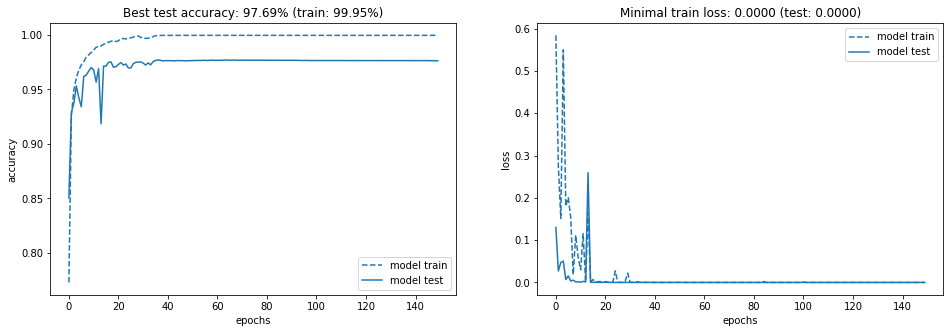

Epoch 10 test acc 0.943968949044586
Epoch 20 test acc 0.9638734076433121
Epoch 30 test acc 0.9684514331210191
Epoch 40 test acc 0.971437101910828
Epoch 50 test acc 0.9736265923566879
Epoch 60 test acc 0.9743232484076433
Epoch 70 test acc 0.9740246815286624
Epoch 80 test acc 0.9747213375796179
Epoch 90 test acc 0.9748208598726115
Epoch 100 test acc 0.975218949044586
Epoch 110 test acc 0.9758160828025477
Epoch 120 test acc 0.976015127388535
Epoch 130 test acc 0.9769108280254777
Epoch 140 test acc 0.9763136942675159
Epoch 150 test acc 0.9762141719745223
Results for model 2


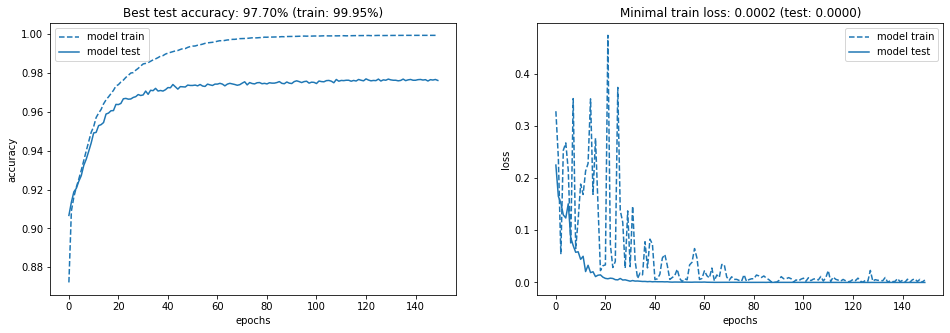

Epoch 10 test acc 0.9532245222929936
Epoch 20 test acc 0.9688495222929936
Epoch 30 test acc 0.9734275477707006
Epoch 40 test acc 0.9739251592356688
Epoch 50 test acc 0.9757165605095541
Epoch 60 test acc 0.9755175159235668
Epoch 70 test acc 0.9756170382165605
Epoch 80 test acc 0.9759156050955414
Epoch 90 test acc 0.9761146496815286
Epoch 100 test acc 0.9758160828025477
Epoch 110 test acc 0.9757165605095541
Epoch 120 test acc 0.9753184713375797
Epoch 130 test acc 0.9753184713375797
Epoch 140 test acc 0.9759156050955414
Epoch 150 test acc 0.9758160828025477
Results for model 3


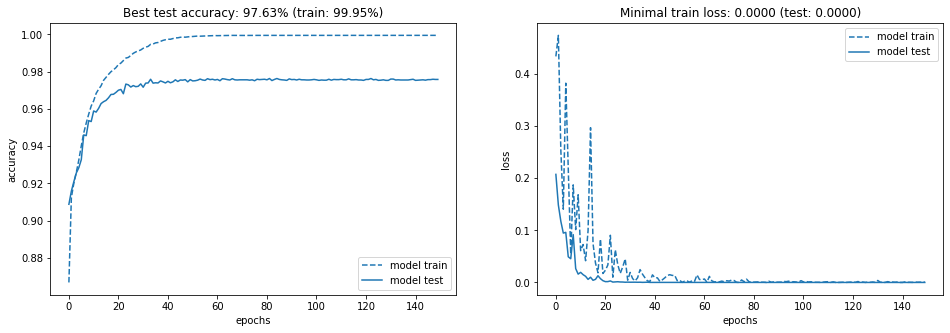

Epoch 10 test acc 0.9559116242038217
Epoch 20 test acc 0.9719347133757962
Epoch 30 test acc 0.9717356687898089
Epoch 40 test acc 0.9746218152866242
Epoch 50 test acc 0.9757165605095541
Epoch 60 test acc 0.9759156050955414
Epoch 70 test acc 0.9762141719745223
Epoch 80 test acc 0.976015127388535
Epoch 90 test acc 0.9765127388535032
Epoch 100 test acc 0.9770103503184714
Epoch 110 test acc 0.9764132165605095
Epoch 120 test acc 0.9761146496815286
Epoch 130 test acc 0.9763136942675159
Epoch 140 test acc 0.9762141719745223
Epoch 150 test acc 0.9766122611464968
Results for model 4


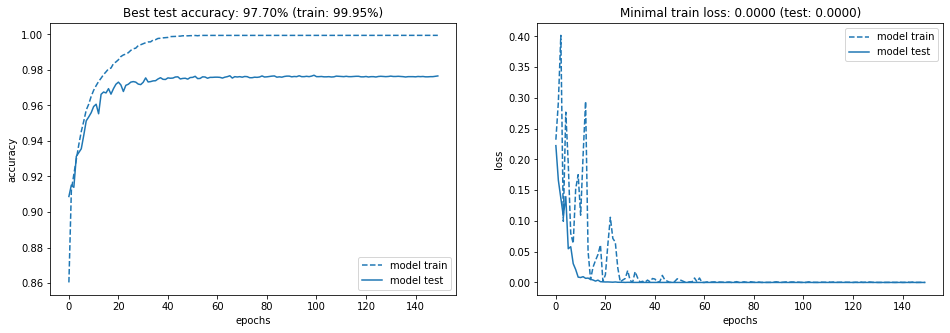

Epoch 10 test acc 0.9557125796178344
Epoch 20 test acc 0.9692476114649682
Epoch 30 test acc 0.9719347133757962
Epoch 40 test acc 0.9727308917197452
Epoch 50 test acc 0.9750199044585988
Epoch 60 test acc 0.9747213375796179
Epoch 70 test acc 0.9747213375796179
Epoch 80 test acc 0.9740246815286624
Epoch 90 test acc 0.9747213375796179
Epoch 100 test acc 0.9748208598726115
Epoch 110 test acc 0.9748208598726115
Epoch 120 test acc 0.9747213375796179
Epoch 130 test acc 0.9746218152866242
Epoch 140 test acc 0.9746218152866242
Epoch 150 test acc 0.9745222929936306
Results for model 5


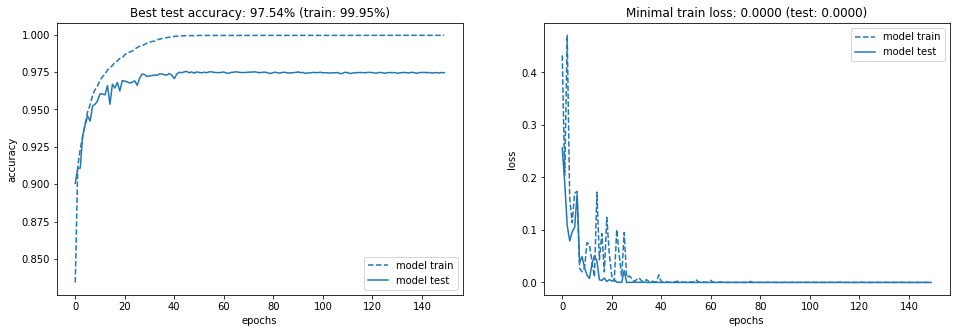

Epoch 10 test acc 0.942078025477707
Epoch 20 test acc 0.964968152866242
Epoch 30 test acc 0.9717356687898089
Epoch 40 test acc 0.9690485668789809
Epoch 50 test acc 0.9759156050955414
Epoch 60 test acc 0.976015127388535
Epoch 70 test acc 0.976015127388535
Epoch 80 test acc 0.9776074840764332
Epoch 90 test acc 0.9770103503184714
Epoch 100 test acc 0.9776074840764332
Epoch 110 test acc 0.9772093949044586
Epoch 120 test acc 0.9778065286624203
Epoch 130 test acc 0.9775079617834395
Epoch 140 test acc 0.9778065286624203
Epoch 150 test acc 0.9773089171974523
Results for model 6


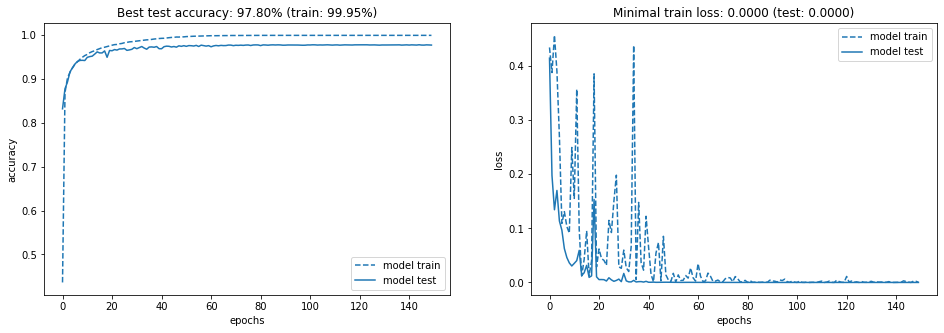

Epoch 10 test acc 0.9736265923566879
Epoch 20 test acc 0.9774084394904459
Epoch 30 test acc 0.9773089171974523
Epoch 40 test acc 0.9768113057324841
Epoch 50 test acc 0.9773089171974523
Epoch 60 test acc 0.9776074840764332
Epoch 70 test acc 0.9780055732484076
Epoch 80 test acc 0.977906050955414
Epoch 90 test acc 0.9777070063694268
Epoch 100 test acc 0.9781050955414012
Epoch 110 test acc 0.9774084394904459
Epoch 120 test acc 0.9776074840764332
Epoch 130 test acc 0.9780055732484076
Epoch 140 test acc 0.9778065286624203
Epoch 150 test acc 0.9780055732484076
Results for model 7


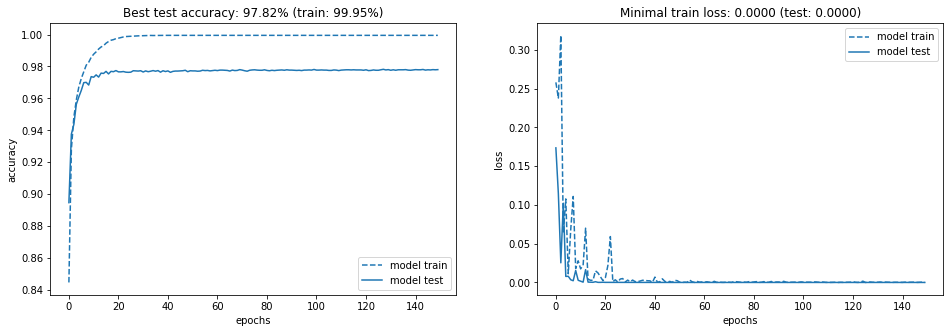

Epoch 10 test acc 0.9341162420382165
Epoch 20 test acc 0.9488455414012739
Epoch 30 test acc 0.9571058917197452
Epoch 40 test acc 0.9601910828025477
Epoch 50 test acc 0.9618829617834395
Epoch 60 test acc 0.9682523885350318
Epoch 70 test acc 0.9672571656050956
Epoch 80 test acc 0.9685509554140127
Epoch 90 test acc 0.9705414012738853
Epoch 100 test acc 0.9703423566878981
Epoch 110 test acc 0.9700437898089171
Epoch 120 test acc 0.9715366242038217
Epoch 130 test acc 0.9728304140127388
Epoch 140 test acc 0.9736265923566879
Epoch 150 test acc 0.9728304140127388
Results for model 8


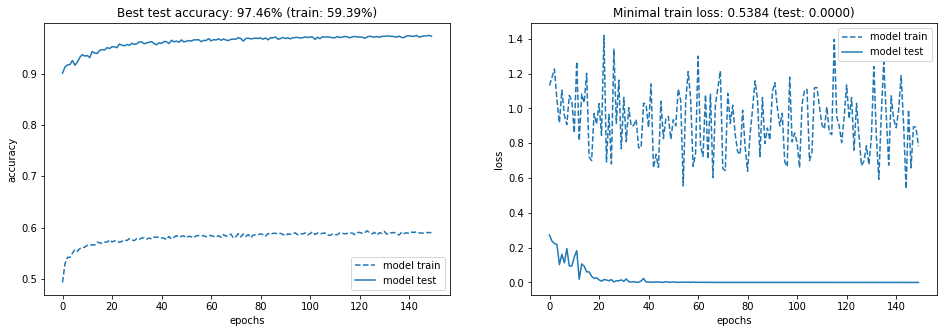

Results for model 1


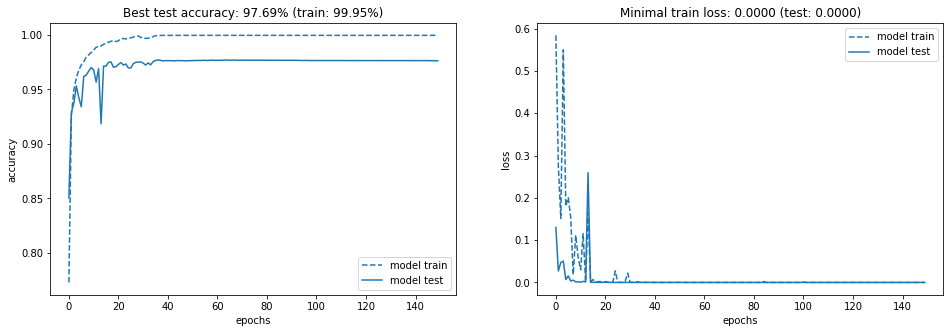

Results for model 2


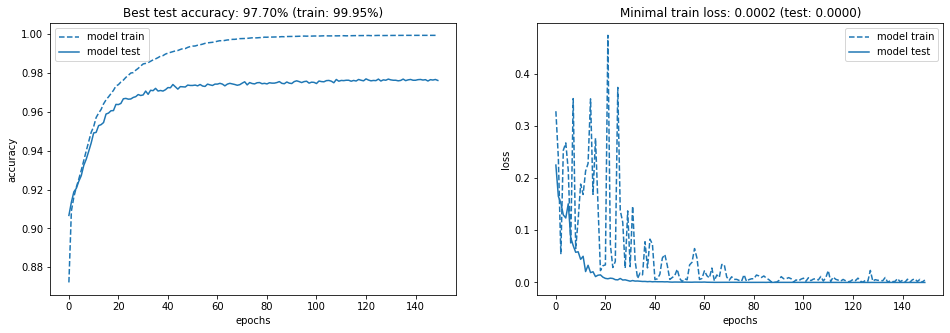

Results for model 3


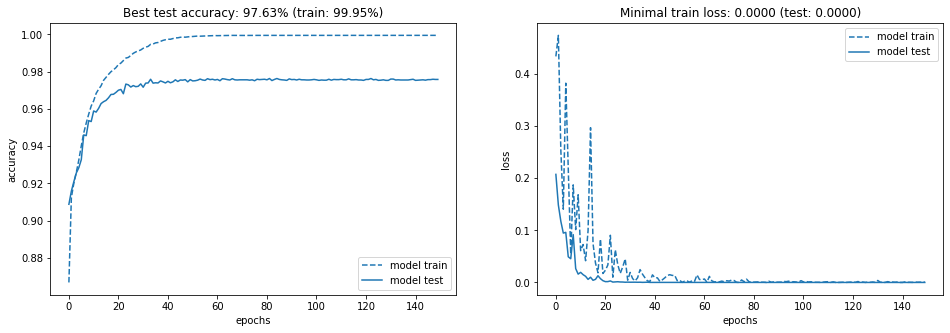

Results for model 4


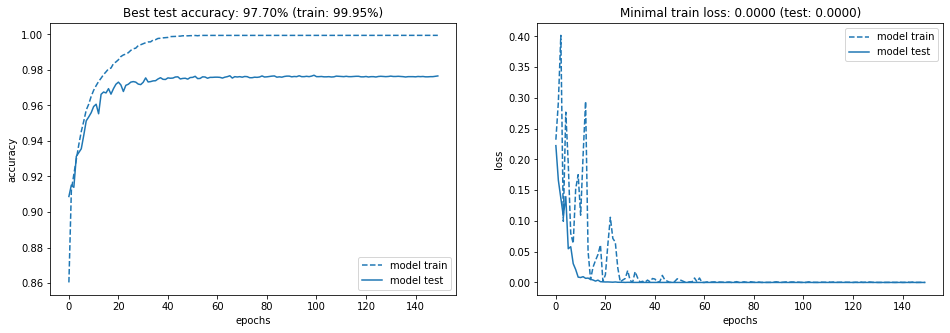

Results for model 5


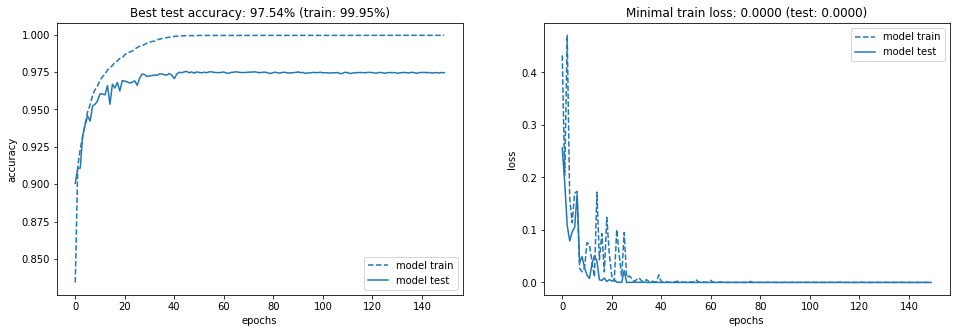

Results for model 6


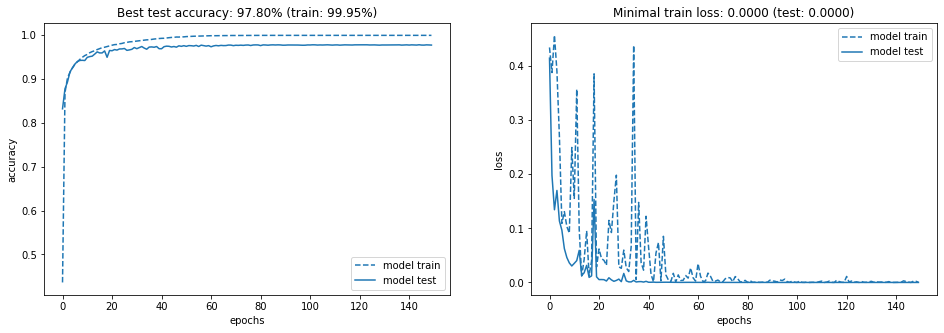

Results for model 7


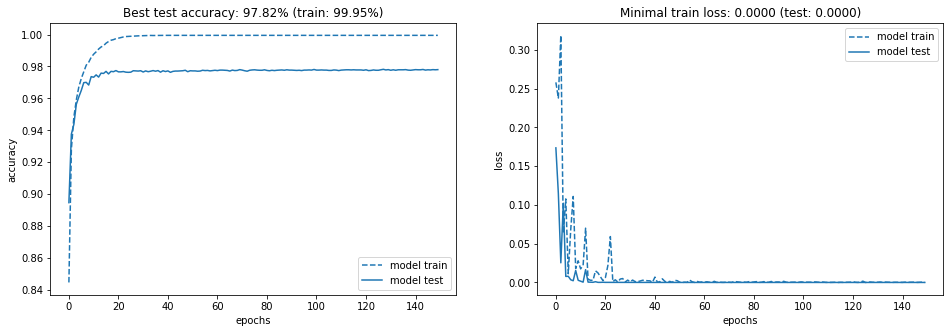

Results for model 8


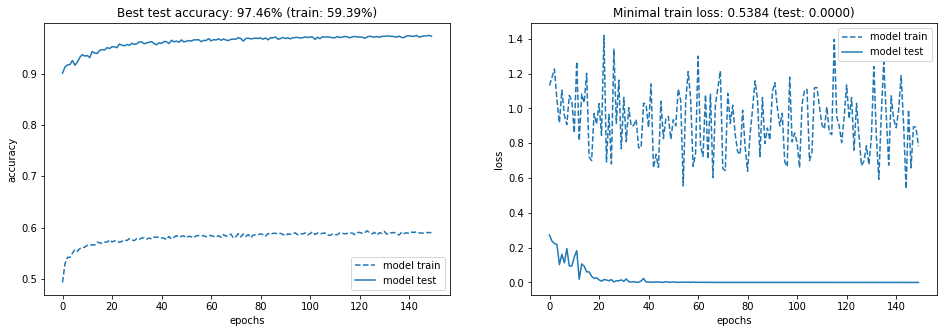

In [8]:
learning_rates = [0.2, 0.05, 0.05, 0.05, 0.05, 0.3, 0.05, 0.05]
histories_bp_mnist = []
for i, (model, lr) in enumerate(zip(models, learning_rates)): 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    history = trainer.train(model, optimizer, n_epochs=150)
    histories_bp_mnist.append(history)
    print(f'Results for model {i+1}')
    show_results(model=history)
for i, history in enumerate(histories_bp_mnist):
    print(f'Results for model {i+1}')
    show_results(model=history)

# DFA

In [9]:
# based on https://github.com/lightonai/principled-dfa-training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import OrderedDict

class AsymmetricFeedback(nn.Module):
    """
    Detach local parts of the graph to prevent gradients from flowing.
    """
    def forward(self, input):
        output = input.detach() #Returns a new Tensor, detached from the current graph. The result will never require gradient.
        output.requires_grad = True
        return output

class AsymmetricSequential(nn.Sequential):
    def __init__(self, *args):
        super(AsymmetricSequential, self).__init__(*args)
        self.layers_units = OrderedDict()  # will store number of units for every layer
        self.random_matrix = None  # will store the biggest random matrix
        self.layers_input = OrderedDict()  # will store layers input to compute local gradients

    def build_feedback(self, input):
        """Generate  biggest random matrix"""
        layer_counter = 0
        for module in self._modules.values():
            if isinstance(module, AsymmetricFeedback):
                layer_counter += 1
                self.layers_units[f'layer{layer_counter}'] = np.prod(input.shape[1:])
            input = module(input)

        classes = np.prod(input.shape[1:])
        max_number_of_units = max(self.layers_units.values())
        self.random_matrix = torch.randn(classes, max_number_of_units) / np.sqrt(max_number_of_units * classes)
        self.random_matrix = self.random_matrix.to(device)
    
    def forward(self, input):
        layer_counter = 0
        for module in self._modules.values():
            if isinstance(module, AsymmetricFeedback):
                layer_counter += 1
                self.layers_input[f'layer{layer_counter}'] = input
            input = module(input)
        return input

    def backward(self, error):
        error = error.to(device)
        random_gradient = error @ self.random_matrix
        for layer, input in self.layers_input.items():
            number_of_units = self.layers_units[layer]
            local_random_gradient = random_gradient[:input.shape[0], :number_of_units]
            local_random_gradient = local_random_gradient.view(*input.shape)
            local_random_gradient = local_random_gradient.to(device)
            input.backward(local_random_gradient)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
input_sample, _ = next(iter(train_loader))

In [11]:
torch.manual_seed(1)
# 7x240 Tanh
model1 = AsymmetricSequential(nn.Linear(784, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(), 
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(240, 240),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(240, 10))
# 1x800 Tanh
model2 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
# 2x800 Tanh
model3 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
# 3x800 Tanh
model4 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
# 4x800 Tanh
model5 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
# 2x800 Logistic
model6 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.Sigmoid(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Sigmoid(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
# 2x800 ReLU
model7 = AsymmetricSequential(nn.Linear(784, 800),
                            nn.ReLU(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.ReLU(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
# 2x800 Tanh + DO
model8 = AsymmetricSequential(nn.Dropout(0.1),
                            nn.Linear(784, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 800),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(800, 10))
models = [model1, model2, model3, model4, model5, model6, model7, model8]

Epoch 10 test acc 0.9681528662420382
Epoch 20 test acc 0.9721337579617835
Epoch 30 test acc 0.9715366242038217
Epoch 40 test acc 0.9716361464968153
Epoch 50 test acc 0.9719347133757962
Epoch 60 test acc 0.9720342356687898
Epoch 70 test acc 0.9720342356687898
Epoch 80 test acc 0.9722332802547771
Epoch 90 test acc 0.9724323248407644
Epoch 100 test acc 0.9724323248407644
Epoch 110 test acc 0.9723328025477707
Epoch 120 test acc 0.9723328025477707
Epoch 130 test acc 0.9723328025477707
Epoch 140 test acc 0.9723328025477707
Epoch 150 test acc 0.9721337579617835
Results for model 1


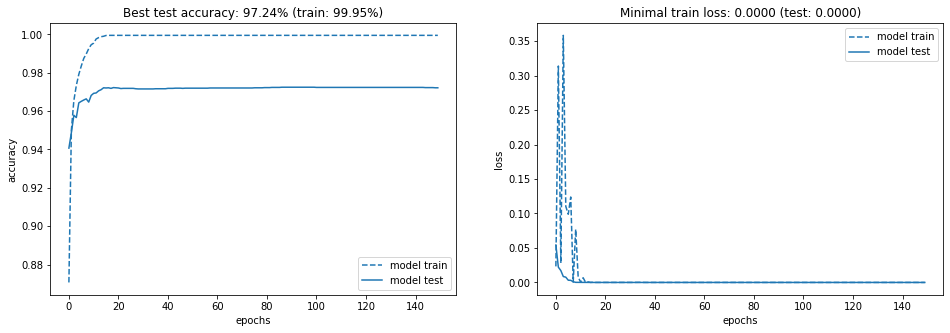

Epoch 10 test acc 0.9719347133757962
Epoch 20 test acc 0.976015127388535
Epoch 30 test acc 0.9772093949044586
Epoch 40 test acc 0.9775079617834395
Epoch 50 test acc 0.9775079617834395
Epoch 60 test acc 0.9775079617834395
Epoch 70 test acc 0.9778065286624203
Epoch 80 test acc 0.9777070063694268
Epoch 90 test acc 0.9776074840764332
Epoch 100 test acc 0.977906050955414
Epoch 110 test acc 0.977906050955414
Epoch 120 test acc 0.9778065286624203
Epoch 130 test acc 0.9778065286624203
Epoch 140 test acc 0.9781050955414012
Epoch 150 test acc 0.9778065286624203
Results for model 2


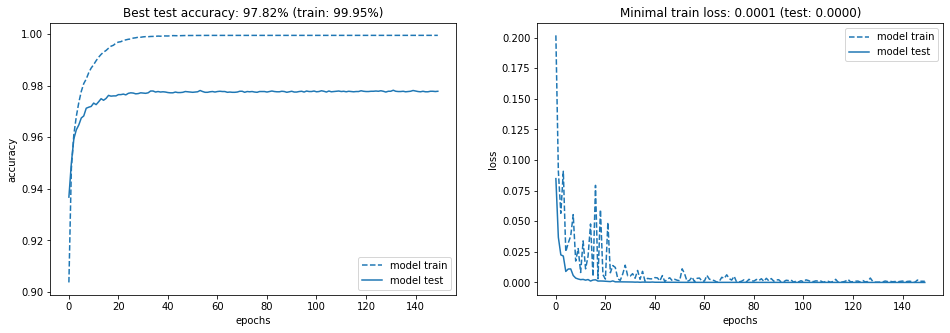

Epoch 10 test acc 0.9729299363057324
Epoch 20 test acc 0.9766122611464968
Epoch 30 test acc 0.9767117834394905
Epoch 40 test acc 0.9768113057324841
Epoch 50 test acc 0.9773089171974523
Epoch 60 test acc 0.9775079617834395
Epoch 70 test acc 0.9772093949044586
Epoch 80 test acc 0.9776074840764332
Epoch 90 test acc 0.9774084394904459
Epoch 100 test acc 0.977109872611465
Epoch 110 test acc 0.9774084394904459
Epoch 120 test acc 0.977109872611465
Epoch 130 test acc 0.9774084394904459
Epoch 140 test acc 0.9772093949044586
Epoch 150 test acc 0.9772093949044586
Results for model 3


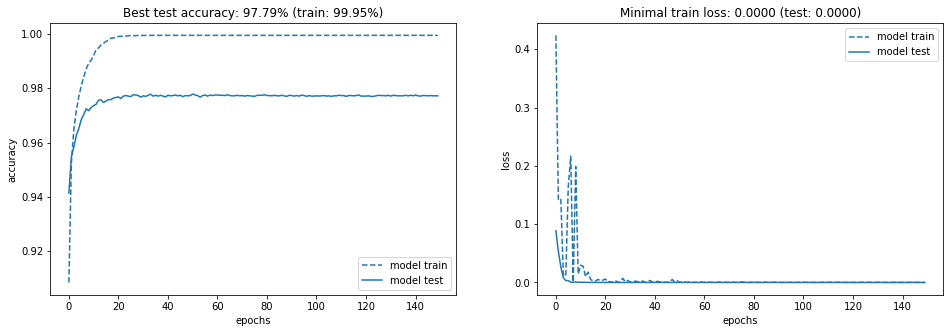

Epoch 10 test acc 0.9708399681528662
Epoch 20 test acc 0.9758160828025477
Epoch 30 test acc 0.9766122611464968
Epoch 40 test acc 0.9765127388535032
Epoch 50 test acc 0.9768113057324841
Epoch 60 test acc 0.9769108280254777
Epoch 80 test acc 0.9766122611464968
Epoch 90 test acc 0.9766122611464968
Epoch 100 test acc 0.9767117834394905
Epoch 110 test acc 0.9765127388535032
Epoch 120 test acc 0.9766122611464968
Epoch 130 test acc 0.9766122611464968
Epoch 140 test acc 0.9767117834394905
Epoch 150 test acc 0.9768113057324841
Results for model 4


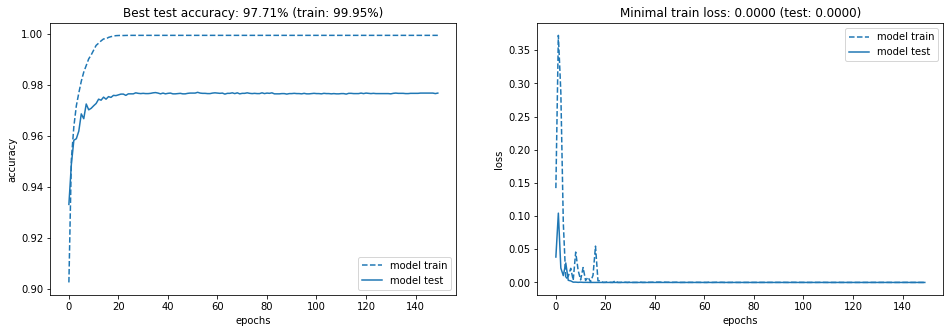

Epoch 10 test acc 0.9735270700636943
Epoch 20 test acc 0.9741242038216561
Epoch 30 test acc 0.9740246815286624
Epoch 40 test acc 0.974422770700637
Epoch 50 test acc 0.9742237261146497
Epoch 60 test acc 0.9742237261146497
Epoch 70 test acc 0.9743232484076433
Epoch 80 test acc 0.9743232484076433
Epoch 90 test acc 0.9742237261146497
Epoch 100 test acc 0.974422770700637
Epoch 110 test acc 0.9745222929936306
Epoch 120 test acc 0.9743232484076433
Epoch 130 test acc 0.974422770700637
Epoch 140 test acc 0.974422770700637
Epoch 150 test acc 0.9743232484076433
Results for model 5


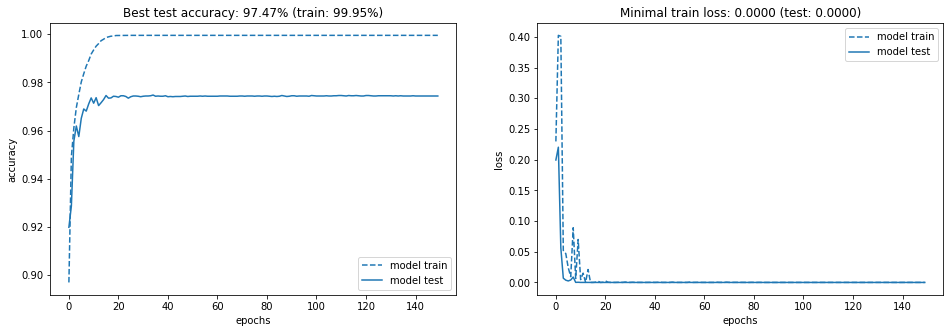

Epoch 10 test acc 0.7576632165605095
Epoch 20 test acc 0.9671576433121019
Epoch 30 test acc 0.9728304140127388
Epoch 40 test acc 0.9761146496815286
Epoch 50 test acc 0.9764132165605095
Epoch 60 test acc 0.9765127388535032
Epoch 70 test acc 0.9768113057324841
Epoch 80 test acc 0.9766122611464968
Epoch 90 test acc 0.9761146496815286
Epoch 100 test acc 0.9767117834394905
Epoch 110 test acc 0.9767117834394905
Epoch 120 test acc 0.9768113057324841
Epoch 130 test acc 0.977109872611465
Epoch 140 test acc 0.9768113057324841
Epoch 150 test acc 0.9770103503184714
Results for model 6


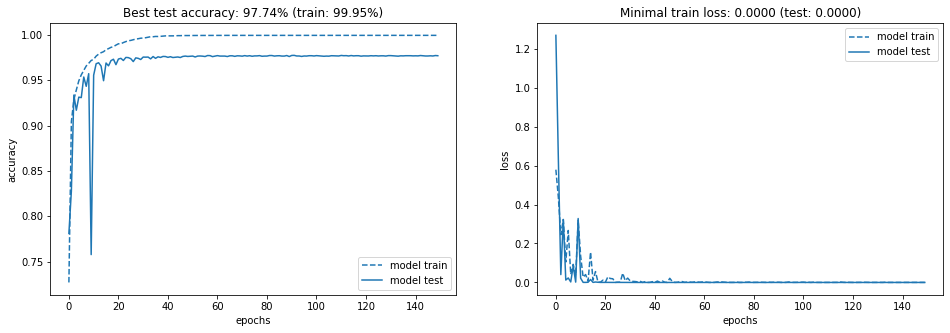

Epoch 10 test acc 0.9139132165605095
Epoch 20 test acc 0.900577229299363
Epoch 30 test acc 0.9618829617834395
Epoch 40 test acc 0.9642714968152867
Epoch 50 test acc 0.9726313694267515
Epoch 60 test acc 0.975218949044586
Epoch 70 test acc 0.9726313694267515
Epoch 80 test acc 0.9742237261146497
Epoch 90 test acc 0.9741242038216561
Epoch 100 test acc 0.972531847133758
Epoch 110 test acc 0.9753184713375797
Epoch 120 test acc 0.9731289808917197
Epoch 130 test acc 0.9743232484076433
Epoch 140 test acc 0.9743232484076433
Epoch 150 test acc 0.9743232484076433
Results for model 7


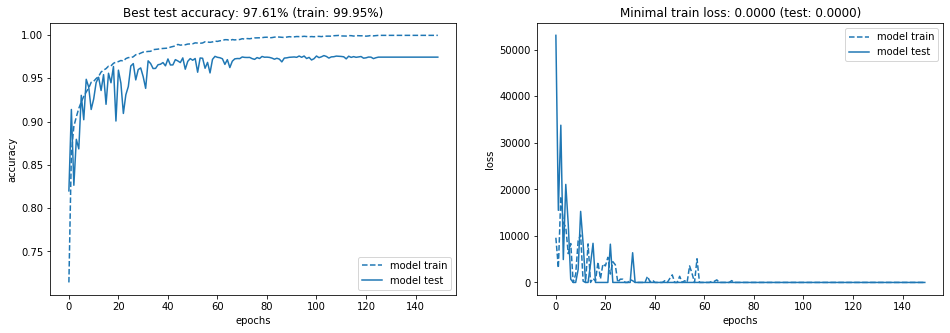

Epoch 10 test acc 0.9684514331210191
Epoch 20 test acc 0.9736265923566879
Epoch 30 test acc 0.9745222929936306
Epoch 40 test acc 0.9751194267515924
Epoch 50 test acc 0.9777070063694268
Epoch 60 test acc 0.9762141719745223
Epoch 70 test acc 0.9767117834394905
Epoch 80 test acc 0.9778065286624203
Epoch 90 test acc 0.9786027070063694
Epoch 100 test acc 0.9791003184713376
Epoch 110 test acc 0.9788017515923567
Epoch 120 test acc 0.9782046178343949
Epoch 130 test acc 0.9793988853503185
Epoch 140 test acc 0.9801950636942676
Epoch 150 test acc 0.9796974522292994
Results for model 8


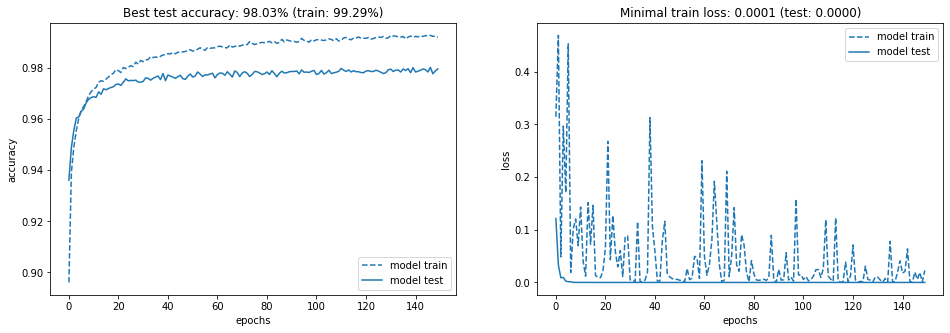

Results for model 1


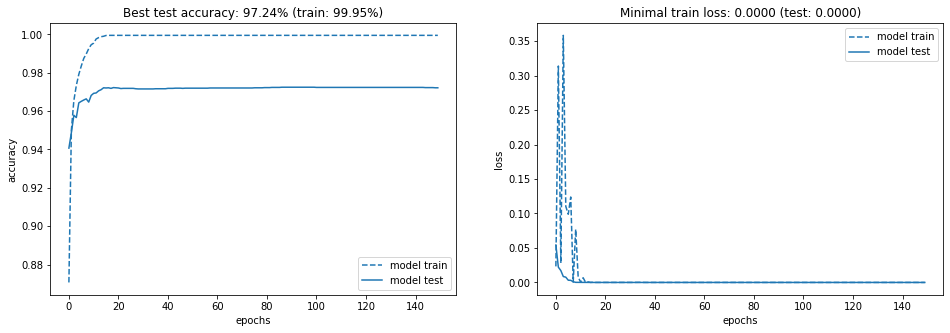

Results for model 2


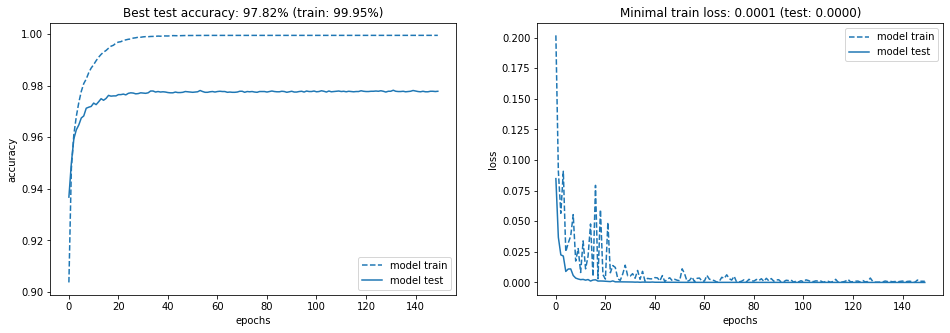

Results for model 3


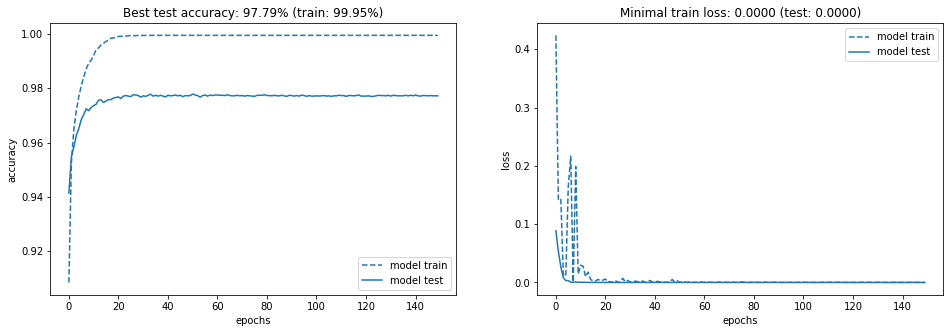

Results for model 4


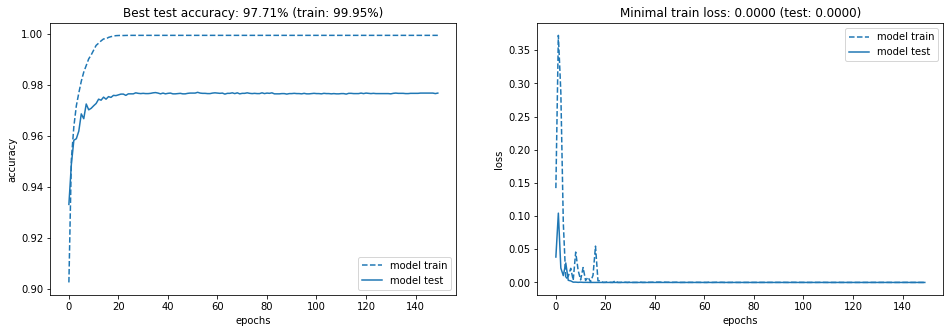

Results for model 5


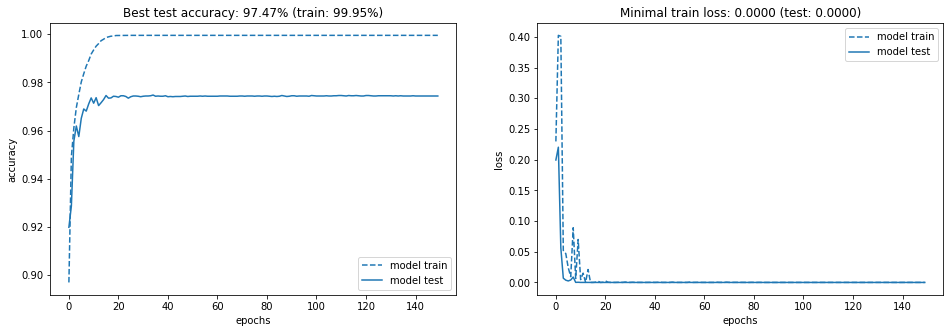

Results for model 6


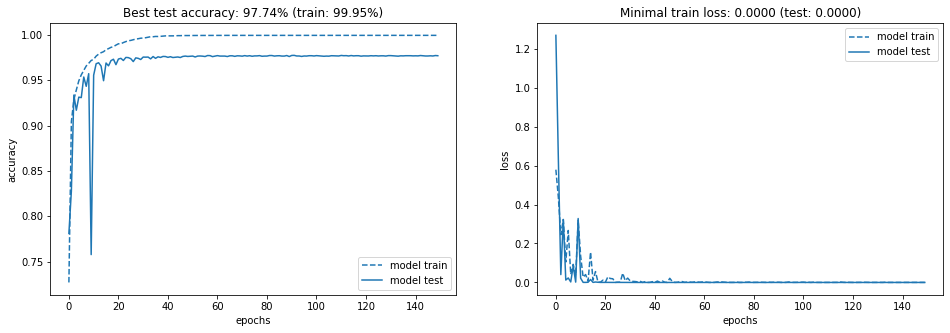

Results for model 7


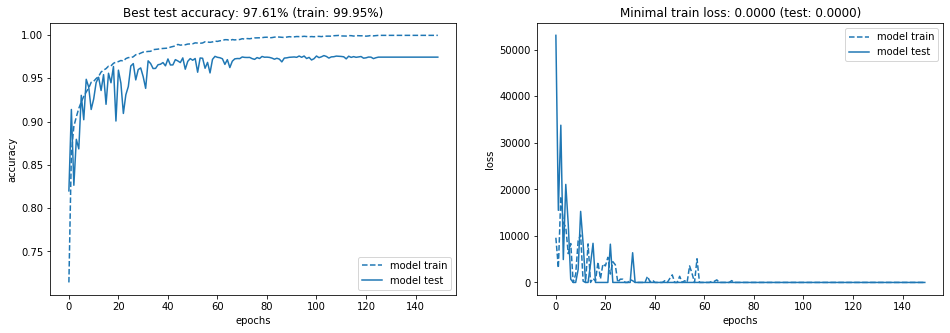

Results for model 8


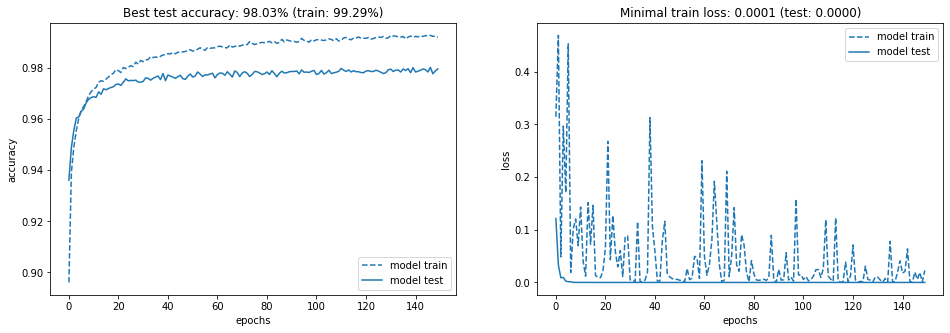

In [12]:
learning_rates = [0.2, 0.05, 0.05, 0.05, 0.05, 0.3, 0.05, 0.05]
histories_dfa_mnist = []
for i, (model, lr) in enumerate(zip(models, learning_rates)): 
    model.build_feedback(input_sample)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    history = trainer.train(model, optimizer, n_epochs=150, dfa=True)
    histories_dfa_mnist.append(history)
    print(f'Results for model {i+1}')
    show_results(model=history)
for i, history in enumerate(histories_dfa_mnist):
    print(f'Results for model {i+1}')
    show_results(model=history)

# CIFAR-10

In [13]:
def load_cifar10(train=True, shrinkage=None):
    dataset = torchvision.datasets.CIFAR10(
        root='.',
        download=True,
        train=train,
        transform=Compose([ToTensor(), Lambda(torch.flatten)])
    )
    if shrinkage:
        dataset_size = len(dataset)
        perm = torch.randperm(dataset_size)
        idx = perm[:int(dataset_size * shrinkage)]
        return torch.utils.data.Subset(dataset, idx)
    return dataset

train_dataset = load_cifar10(train=True)
test_dataset = load_cifar10(train=False)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
batch_size = 64
trainer = ModelTrainer(train_dataset, test_dataset, batch_size=batch_size)
n_epochs = 150
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
input_sample, _ = next(iter(train_loader))

# CIFAR-10 BP

In [15]:
torch.manual_seed(1)

# 1x1000 Tanh
model1 = nn.Sequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 10))
# 3x1000 Tanh
model2 = nn.Sequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            nn.Linear(1000, 10))
# 3x1000 Tanh + DO
model3 = nn.Sequential(nn.Dropout(0.1),
                            nn.Linear(3072, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(1000, 10))
models = [model1, model2, model3]

Epoch 10 test acc 0.38196656050955413
Epoch 20 test acc 0.4498407643312102
Epoch 30 test acc 0.4276472929936306
Epoch 40 test acc 0.4469546178343949
Epoch 50 test acc 0.48128980891719747
Epoch 60 test acc 0.5033837579617835
Epoch 70 test acc 0.45302547770700635
Epoch 80 test acc 0.46208200636942676
Epoch 90 test acc 0.443968949044586
Epoch 100 test acc 0.4906449044585987
Epoch 110 test acc 0.4903463375796178
Epoch 120 test acc 0.4888535031847134
Epoch 130 test acc 0.5100517515923567
Epoch 140 test acc 0.4918391719745223
Epoch 150 test acc 0.5272691082802548
Results for model 1


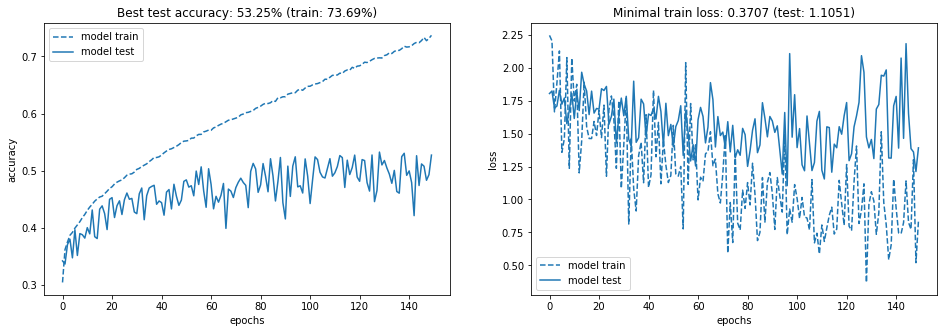

Epoch 10 test acc 0.36186305732484075
Epoch 20 test acc 0.46725716560509556
Epoch 30 test acc 0.432921974522293
Epoch 40 test acc 0.4551154458598726
Epoch 50 test acc 0.4830812101910828
Epoch 60 test acc 0.4863654458598726
Epoch 70 test acc 0.37251194267515925
Epoch 80 test acc 0.44018710191082805
Epoch 90 test acc 0.4915406050955414
Epoch 100 test acc 0.517515923566879
Epoch 110 test acc 0.5117436305732485
Epoch 120 test acc 0.5039808917197452
Epoch 130 test acc 0.46984474522292996
Epoch 140 test acc 0.45720541401273884
Epoch 150 test acc 0.4961186305732484
Results for model 2


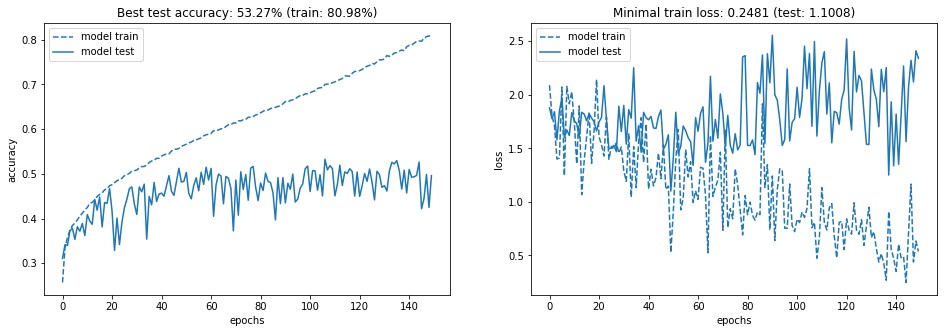

Epoch 10 test acc 0.39490445859872614
Epoch 20 test acc 0.4169984076433121
Epoch 30 test acc 0.4281449044585987
Epoch 40 test acc 0.44745222929936307
Epoch 50 test acc 0.44884554140127386
Epoch 60 test acc 0.45491640127388533
Epoch 70 test acc 0.4634753184713376
Epoch 80 test acc 0.4449641719745223
Epoch 90 test acc 0.45013933121019106
Epoch 100 test acc 0.431031050955414
Epoch 110 test acc 0.46267914012738853
Epoch 120 test acc 0.4654657643312102
Epoch 130 test acc 0.4811902866242038
Epoch 140 test acc 0.47093949044585987
Epoch 150 test acc 0.4710390127388535
Results for model 3


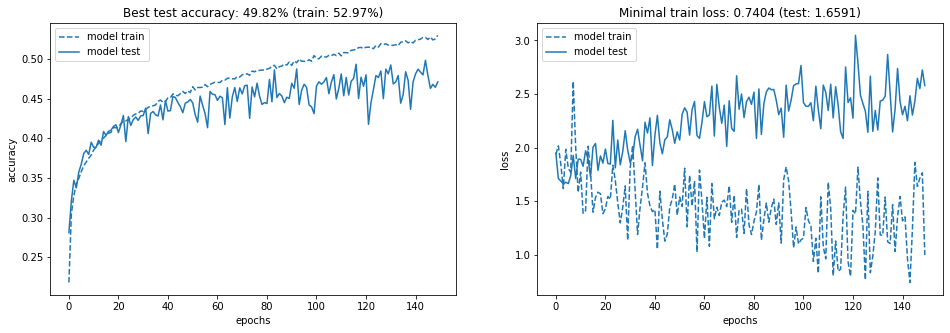

Results for model 1


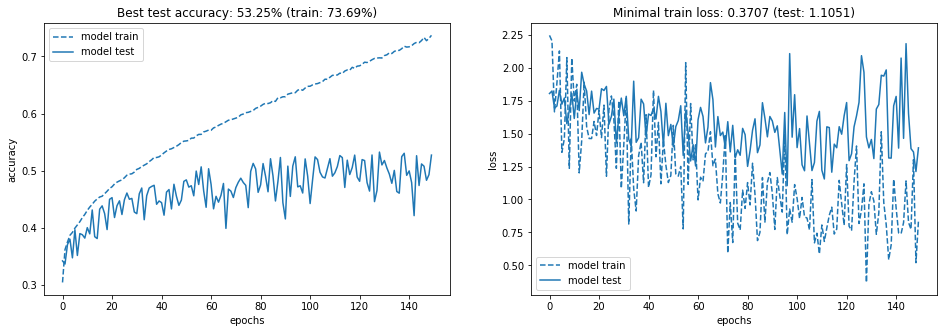

Results for model 2


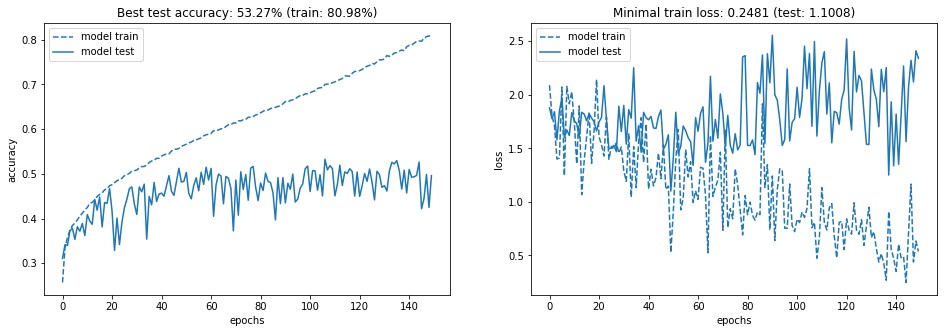

Results for model 3


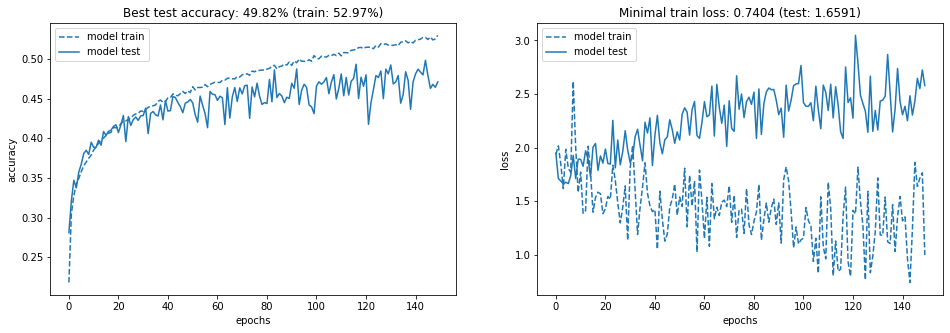

In [16]:
histories_bp_cifar = []
for i, model in enumerate(models): 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    history = trainer.train(model, optimizer, n_epochs=n_epochs)
    histories_bp_cifar.append(history)
    print(f'Results for model {i+1}')
    show_results(model=history)
for i, history in enumerate(histories_bp_cifar):
    print(f'Results for model {i+1}')
    show_results(model=history)

# CIFAR-10 DFA

In [17]:
torch.manual_seed(1)

# 1x1000 Tanh
model1 = AsymmetricSequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 10))
# 3x1000 Tanh
model2 = AsymmetricSequential(nn.Linear(3072, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 10))
# 3x1000 Tanh + DO
model3 = AsymmetricSequential(nn.Dropout(0.1),
                            nn.Linear(3072, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 1000),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            AsymmetricFeedback(),
                            nn.Linear(1000, 10))
models = [model1, model2, model3]

Epoch 10 test acc 0.48039410828025475
Epoch 20 test acc 0.49761146496815284
Epoch 30 test acc 0.5170183121019108
Epoch 40 test acc 0.5187101910828026
Epoch 50 test acc 0.512937898089172
Epoch 60 test acc 0.5257762738853503
Epoch 70 test acc 0.5233877388535032
Epoch 80 test acc 0.5174164012738853
Epoch 90 test acc 0.5224920382165605
Epoch 100 test acc 0.5200039808917197
Epoch 110 test acc 0.5211982484076433
Epoch 120 test acc 0.5184116242038217
Epoch 130 test acc 0.5191082802547771
Epoch 140 test acc 0.5246815286624203
Epoch 150 test acc 0.5161226114649682
Results for model 1


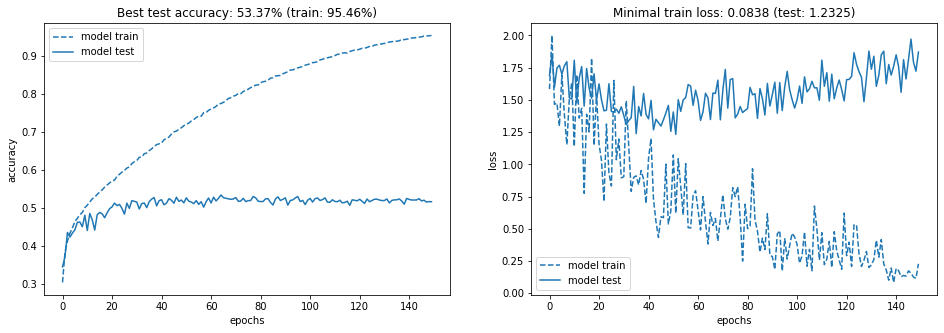

Epoch 10 test acc 0.44914410828025475
Epoch 20 test acc 0.5047770700636943
Epoch 30 test acc 0.5258757961783439
Epoch 40 test acc 0.5200039808917197
Epoch 50 test acc 0.5195063694267515
Epoch 60 test acc 0.5109474522292994
Epoch 70 test acc 0.5176154458598726
Epoch 80 test acc 0.5147292993630573
Epoch 90 test acc 0.5208001592356688
Epoch 100 test acc 0.5179140127388535
Epoch 110 test acc 0.5211982484076433
Epoch 120 test acc 0.5180135350318471
Epoch 130 test acc 0.5193073248407644
Epoch 140 test acc 0.5184116242038217
Epoch 150 test acc 0.515625
Results for model 2


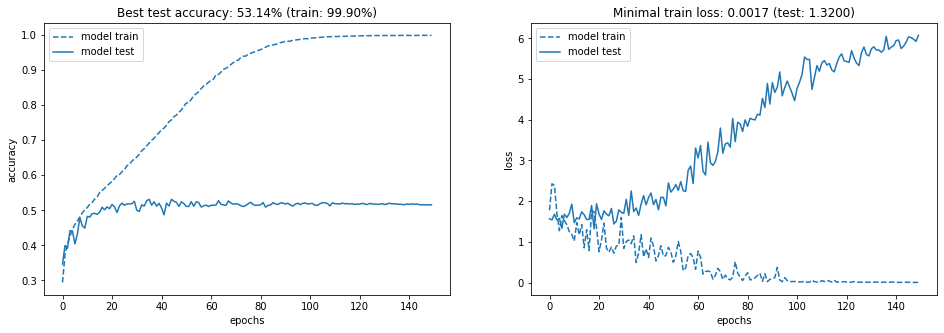

Epoch 10 test acc 0.41421178343949044
Epoch 20 test acc 0.4440684713375796
Epoch 30 test acc 0.46447054140127386
Epoch 40 test acc 0.4710390127388535
Epoch 50 test acc 0.4721337579617834
Epoch 60 test acc 0.4809912420382166
Epoch 70 test acc 0.48328025477707004
Epoch 80 test acc 0.4905453821656051
Epoch 90 test acc 0.48258359872611467
Epoch 100 test acc 0.4955214968152866
Epoch 110 test acc 0.4925358280254777
Epoch 120 test acc 0.49781050955414013
Epoch 130 test acc 0.49860668789808915
Epoch 140 test acc 0.5008957006369427
Epoch 150 test acc 0.5081608280254777
Results for model 3


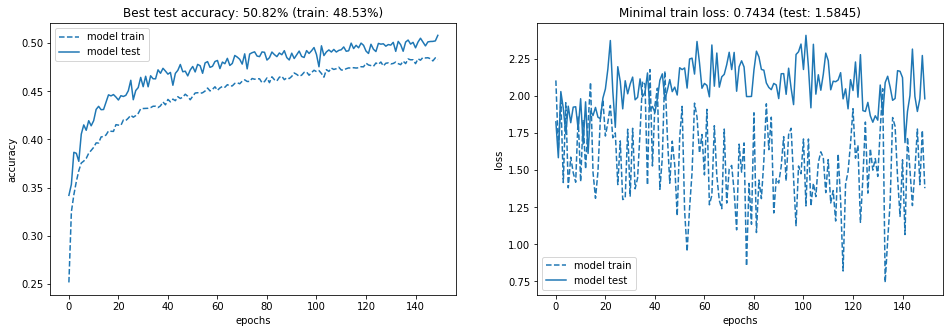

Results for model 1


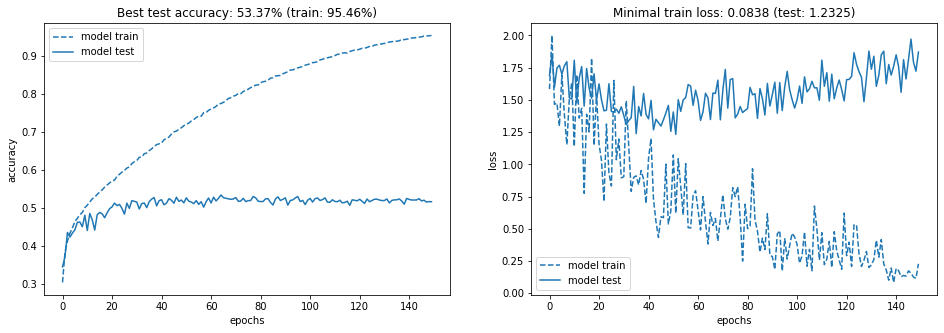

Results for model 2


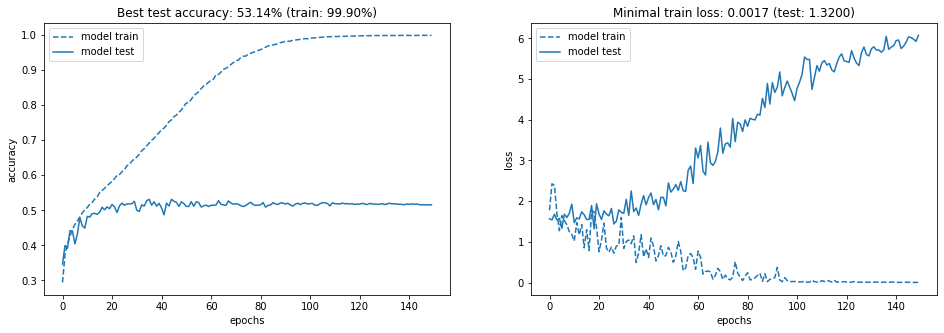

Results for model 3


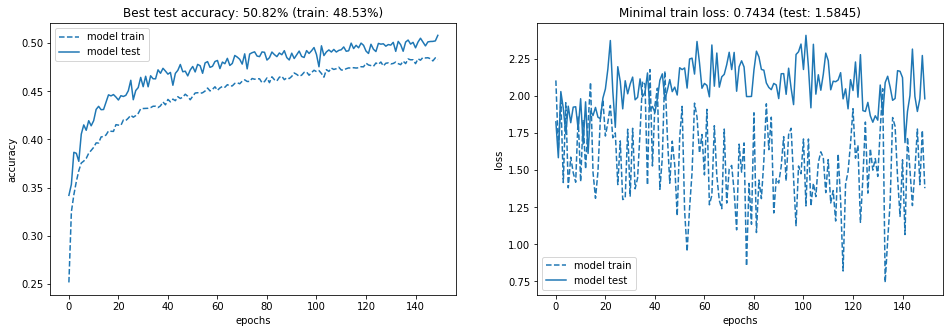

In [18]:
histories_dfa_cifar = []
for i, model in enumerate(models): 
    model.build_feedback(input_sample)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    history = trainer.train(model, optimizer, n_epochs=n_epochs, dfa=True)
    histories_dfa_cifar.append(history)
    print(f'Results for model {i+1}')
    show_results(model=history)
for i, history in enumerate(histories_dfa_cifar):
    print(f'Results for model {i+1}')
    show_results(model=history)